## Calculate adjacency matrix between towns

In [1]:
import pandas as pd
import geopandas as gpd

towns = gpd.read_file('data/towns.geojson')

In [2]:
import networkx as nx
graph = nx.read_graphml('data/graph.graphml')

In [3]:
graph_crs = graph.graph['crs']
towns = towns.to_crs(graph_crs)

In [4]:
try:
  adj_mx = pd.read_pickle('data/adj_mx.pickle')
except:
  from townsnet.preprocessing.adjacency_calculator import AdjacencyCalculator
  blocks = towns.copy()
  blocks.geometry = blocks.geometry.buffer(0.01)
  ac = AdjacencyCalculator(blocks=blocks, graph=graph)
  adj_mx = ac.get_dataframe()
  adj_mx.to_pickle('data/adj_mx.pickle')

In [5]:
adj_mx.head()

,0,1,2,3,4,5,6,7,8,9,...,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930
0,0.0,46.7,47.9,42.5,29.6,12.1,73.9,99.1,29.8,64.9,...,741.6,713.6,706.1,724.7,825.9,825.9,796.8,733.5,728.7,770.5
1,46.7,0.0,1.2,16.2,73.3,55.8,107.4,132.6,56.8,37.4,...,696.4,668.4,660.9,679.5,780.7,780.7,751.6,688.3,683.5,725.3
2,47.9,1.2,0.0,17.4,74.5,57.0,108.6,133.8,55.6,38.6,...,695.2,667.2,659.7,678.3,779.5,779.5,750.4,687.1,682.3,724.1
3,42.5,16.2,17.4,0.0,69.1,51.6,103.2,128.4,59.1,34.4,...,711.1,683.1,675.6,694.2,795.4,795.4,766.3,703.0,698.2,740.0
4,29.6,73.3,74.5,69.1,0.0,17.5,100.5,125.7,56.4,91.5,...,768.2,740.2,732.7,751.3,852.5,852.5,823.4,760.1,755.3,797.1


## Distribute population between towns

In [6]:
water = gpd.read_file('data/water.geojson').to_crs(towns.crs)
rayons = gpd.read_file('data/rayons.geojson').to_crs(towns.crs)
okrugs = gpd.read_file('data/okrugs.geojson').to_crs(towns.crs).reset_index(drop=True)
okrugs['population'] = okrugs['2023']
okrugs = gpd.overlay(okrugs, water, how='difference')

In [7]:
towns['is_city'] = towns['rural settlement'].apply(lambda x : x.lower().find('город')>=0)

In [8]:
from townsnet.preprocessing.population_filler import PopulationFiller
pf = PopulationFiller(units=okrugs, towns=towns, adjacency_matrix=adj_mx)
towns = pf.fill()

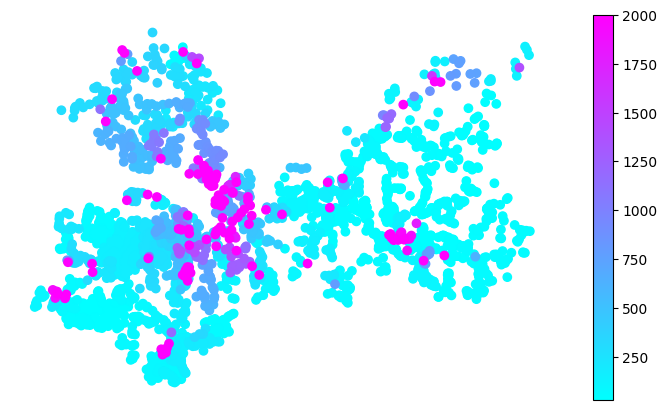

In [9]:
towns.sort_values(by='population').plot(
  column='population', 
  vmax=2000, 
  cmap='cool', 
  legend=True, 
  figsize=(10,5)
).set_axis_off()

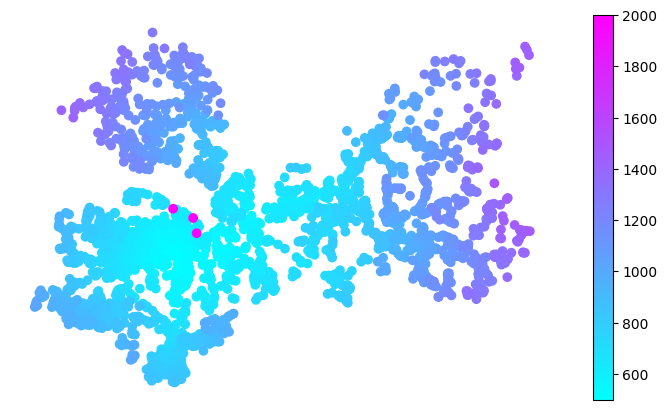

In [10]:
towns.sort_values(by='median_time').plot(
  column='median_time', 
  vmax=2000, 
  cmap='cool', 
  legend=True, 
  figsize=(10,5)
).set_axis_off()

## Region model initialization

In [11]:
from townsnet.models.region import Region

region = Region(
  towns=towns,
  okrugs=okrugs, 
  rayons=rayons, 
  adjacency_matrix=adj_mx
)

In [12]:
region.to_gdf()

,name,population,geometry,okrug_name,rayon_name
id,,,,,
0,Болото,111,POINT (543142.339 6580637.744),Борское сельское поселение,Бокситогорский муниципальный район
1,Большой Остров,116,POINT (544532.929 6593228.214),Борское сельское поселение,Бокситогорский муниципальный район
2,Бор,116,POINT (544895.402 6593052.876),Борское сельское поселение,Бокситогорский муниципальный район
3,Бороватое,114,POINT (543993.111 6589582.121),Борское сельское поселение,Бокситогорский муниципальный район
4,Бочево,108,POINT (538540.110 6576793.684),Борское сельское поселение,Бокситогорский муниципальный район
...,...,...,...,...,...
2926,Апраксин Бор,96,POINT (399059.742 6560341.471),Трубникоборское сельское поселение,Тоснненский муниципальный район
2927,Александровка,98,POINT (403967.171 6562087.081),Трубникоборское сельское поселение,Тоснненский муниципальный район
2928,Большая Горка,100,POINT (413116.740 6573793.279),Трубникоборское сельское поселение,Тоснненский муниципальный район


In [13]:
towns.to_parquet('data/_towns.parquet')
okrugs.to_parquet('data/_okrugs.parquet')
rayons.to_parquet('data/_rayons.parquet')
adj_mx.to_pickle('data/_adj_mx.pickle')

## Services fetch

- **Образование**: детсады, школы, вузы
- **Культура**: музеи, театры, библиотеки
- **Спорт**: спортивные центры, спортивные залы, спортивные комплексы
- **Туризм**: ОКН, гостиничный бизнес
- **Здравоохранение**: поликлиники, больницы

In [14]:
infrastructures = {
  'education': [
    {
      'name':'kindergarten',
      'tags': {'amenity':'kindergarten'}
    }, 
    {
      'name':'school',
      'tags':{'amenity':'school'}
    }
  ],
  'culture': [
    {
      'name':'museum', 
      'tags':{'tourism':'museum'}
    }, 
    {
      'name':'theatre', 
      'tags':{'amenity':'theatre'}
    }
  ],
  'sport': [
    {
      'name':'pitch',
      'tags':{'leisure':'pitch'}
    }
  ],
  'tourism': [
    {
      'name':'hotel',
      'tags':{'tourism':'hotel'}
    }
  ],
  'healthcare': [
    {
      'name':'polyclinic',
      'tags':{'amenity':'clinic'}
    }, 
    {
      'name':'hospital',
      'tags':{'amenity':'hospital'}
    }
  ]
}

In [15]:
import osmnx as ox
from townsnet.preprocessing.capacity_filler import CapacityFiller

boundaries = gpd.read_file('data/region.geojson')
polygon = boundaries.loc[0,'geometry']

for infrastructure, service_types in infrastructures.items():
  for st_dict in service_types:
    name = st_dict['name']
    tags = st_dict['tags']
    print(infrastructure, name)
    service_type = region[name]
    gdf = ox.features_from_polygon(polygon, tags).reset_index(drop=True).to_crs(region.crs)
    gdf = CapacityFiller(services=gdf, is_osm=True, service_type=service_type).fill()
    gdf.to_parquet(f'data/_services_{name}.parquet')

education kindergarten


/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/osmnx/_overpass.py:245: UserWarning: This area is 51 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/osmnx/_overpass.py:245: UserWarning: This area is 51 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


education school


/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/osmnx/_overpass.py:245: UserWarning: This area is 51 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


culture museum


/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/osmnx/_overpass.py:245: UserWarning: This area is 51 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


culture theatre


/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/osmnx/_overpass.py:245: UserWarning: This area is 51 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


sport pitch


/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/osmnx/_overpass.py:245: UserWarning: This area is 51 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


tourism hotel


/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/osmnx/_overpass.py:245: UserWarning: This area is 51 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


healthcare polyclinic


/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/osmnx/_overpass.py:245: UserWarning: This area is 51 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


healthcare hospital


/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
